In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import simbench as sb
import warnings

# Get notebook directory and parent (project root)
notebook_dir = Path(os.getcwd())
project_dir = notebook_dir.parent

# Add project directory to Python path
sys.path.append(str(project_dir))

# Import prepare_results from results_prep
from src.results_prep import prepare_results

In [2]:
# Set the maximum number of rows to display in total
pd.set_option('display.max_rows', 300)

# Set the minimum number of rows to display before truncating
pd.set_option('display.min_rows', 200)

# set the max columns to none
pd.set_option('display.max_columns', None)

In [3]:
# Define necessary OPEX parameters
maintenance_percentage_trafo = 0.02 # Source: Verteilnetzstudie Hessen
maintenance_percentage_line = 0.01  # Source: Verteilnetzstudie Hessen

equity_rate = 0.0769  # Source: Eigenkapitalzinssatz für Neuinvestitionen inkl. Gewerbesteuer, BNetzA
equity_percentage = 0.4  # Source: Pauschale Eigenkapitalquote,BNetzA
debt_rate = 0.0171  # Source: Kalkulatorischer Fremdkapitalzinssatz 4. Periode, BNetzA

current_HP_percentage = 5.7 # Source: bdew Report "Wie heizt Deutschland"

hp_tariff_discount = 0.6 # $14a EnWG

sales_tax = 0.19

payback_period_line = 40  # Source: BNetzA, in years
payback_period_trafo = 30  # Source: BNetzA, in years
discount_rate = (equity_percentage * equity_rate) + ((1 - equity_percentage) * debt_rate) # WACC calculation

In [4]:
# Set parameters
params = {
    'notebook_dir': project_dir,
    'payback_period_line': payback_period_line,
    'payback_period_trafo': payback_period_trafo,
    'discount_rate': discount_rate,
    'equity_rate': equity_rate,
    'equity_percentage': equity_percentage,
    'debt_rate': debt_rate,
    'maintenance_percentage_trafo': maintenance_percentage_trafo,
    'maintenance_percentage_line': maintenance_percentage_line,
    'hp_tariff_discount': hp_tariff_discount,
    'sales_tax': sales_tax,
}

# Prepare results DataFrame
results_df = prepare_results(**params)

Calculating hierarchical filtered loads...
{'LV': {'1-LV-rural1--0-no_sw': {'total_load': np.float64(0.08), 'filtered_load': np.float64(0.073)}, '1-LV-rural2--0-no_sw': {'total_load': np.float64(0.20200000000000004), 'filtered_load': np.float64(0.056)}, '1-LV-rural3--0-no_sw': {'total_load': np.float64(0.33100000000000007), 'filtered_load': np.float64(0.051)}, '1-LV-semiurb4--0-no_sw': {'total_load': np.float64(0.24300000000000002), 'filtered_load': np.float64(0.11599999999999999)}, '1-LV-semiurb5--0-no_sw': {'total_load': np.float64(0.40900000000000003), 'filtered_load': np.float64(0.07600000000000001)}, '1-LV-urban6--0-no_sw': {'total_load': np.float64(0.44100000000000006), 'filtered_load': np.float64(0.122)}}, 'MV': {'1-MV-rural--0-no_sw': {'total_load': np.float64(17.256), 'filtered_load': np.float64(8.372000000000007)}, '1-MV-semiurb--0-no_sw': {'total_load': np.float64(31.639999999999997), 'filtered_load': np.float64(10.038999999999996)}, '1-MV-urban--0-no_sw': {'total_load': np.

In [5]:
# Filter data for HV-mixed and HV-urban grids
hv_mixed_data = results_df[results_df['grid_code'] == 'HV-mixed'].copy()
hv_urban_data = results_df[results_df['grid_code'] == 'HV-urban'].copy()

# Calculate reinforcement cost per household
hv_mixed_data['cost_per_household'] = hv_mixed_data['total_reinforcement_cost'] / hv_mixed_data['total_households']
hv_urban_data['cost_per_household'] = hv_urban_data['total_reinforcement_cost'] / hv_urban_data['total_households']

# Calculate mean and standard deviation at each HP adoption level
hv_mixed_summary = hv_mixed_data.groupby('HP_percentage')['cost_per_household'].agg(['mean', 'std']).reset_index()
hv_urban_summary = hv_urban_data.groupby('HP_percentage')['cost_per_household'].agg(['mean', 'std']).reset_index()

# Model validation: Peak load increase

In [6]:
hv_data = results_df[results_df['grid_level'] == 'HV']

# Get volume-adjusted mean values for total grid load
total_load = hv_data.groupby('HP_percentage').apply(
    lambda x: (x['HP_percentage_load'] * x['total_households']).sum() / x['total_households'].sum()
).reset_index()
total_load.columns = ['HP_percentage', 'Total grid load (in MW)']

# Calculate average load per household in kW
avg_load = total_load.copy()
avg_load['Avg. load by household (in kW)'] = avg_load['Total grid load (in MW)'] * 1000 / hv_data['total_households'].mean()
avg_load = avg_load.drop('Total grid load (in MW)', axis=1)

# Merge the two metrics
final_table = pd.merge(total_load, avg_load, on='HP_percentage')

# Filter for HP percentages from 0 to 100 in steps of 5
final_table = final_table[final_table['HP_percentage'].isin(range(0, 101, 5))]

# Set HP_percentage as column names and transpose
final_table = final_table.set_index('HP_percentage').transpose()

# Round the values
final_table = final_table.round(2)

final_table

C:\Users\55485\AppData\Local\Temp\ipykernel_8936\4226239280.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_load = hv_data.groupby('HP_percentage').apply(


HP_percentage,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100
Total grid load (in MW),557.82,567.64,580.34,593.78,616.21,638.98,665.01,696.71,729.67,758.41,796.68,828.30,864.82,894.78,938.38,976.26,1015.18,1057.35,1093.76,1130.08,1176.83
Avg. load by household (in kW),1.98,2.01,2.06,2.10,2.18,2.26,2.36,2.47,2.58,2.69,2.82,2.93,3.06,3.17,3.32,3.46,3.60,3.75,3.87,4.00,4.17


# 1. Grid reinforcement cost of rural and urban

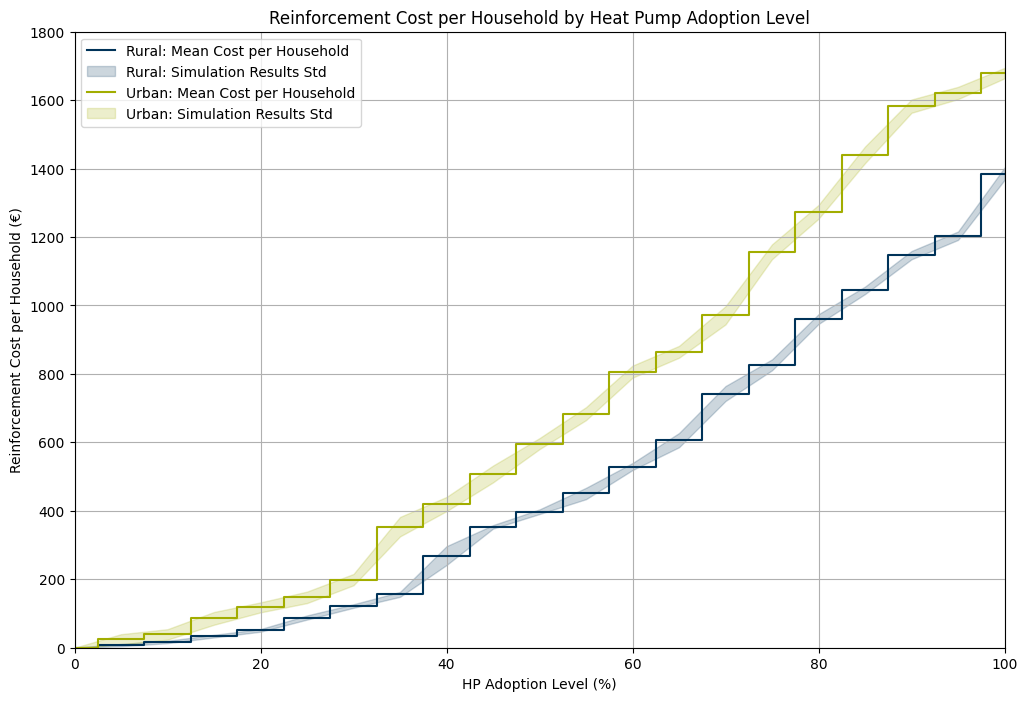

In [7]:
# Plotting
plt.figure(figsize=(12, 8))

# Calculate global min and max y-axis limits across both datasets, with a 5% margin
global_min_y = min(hv_mixed_summary['mean'].min(), hv_urban_summary['mean'].min())
global_max_y = max(hv_mixed_summary['mean'].max(), hv_urban_summary['mean'].max())
y_min = global_min_y
y_max = global_max_y * 1.05  # Adding 5% margin

# Plot stair-step for Distribution Grid - rural (HV-mixed) with corridor
plt.step(hv_mixed_summary['HP_percentage'], hv_mixed_summary['mean'], where='mid', color='#003359', label='Rural: Mean Cost per Household')
plt.fill_between(hv_mixed_summary['HP_percentage'],
                 hv_mixed_summary['mean'] - hv_mixed_summary['std'],
                 hv_mixed_summary['mean'] + hv_mixed_summary['std'],
                 color='#003359', alpha=0.2, label='Rural: Simulation Results Std')

# Plot stair-step for Distribution Grid - urban (HV-urban) with corridor
plt.step(hv_urban_summary['HP_percentage'], hv_urban_summary['mean'], where='mid', color='#A2AD00', label='Urban: Mean Cost per Household')
plt.fill_between(hv_urban_summary['HP_percentage'],
                 hv_urban_summary['mean'] - hv_urban_summary['std'],
                 hv_urban_summary['mean'] + hv_urban_summary['std'],
                 color='#A2AD00', alpha=0.2, label='Urban: Simulation Results Std')

# Labels and title
plt.xlabel('HP Adoption Level (%)')
plt.ylabel('Reinforcement Cost per Household (€)')

# Set x-axis and y-axis limits
plt.xlim(0, 100)
plt.ylim(0, 1800)
    
plt.title('Reinforcement Cost per Household by Heat Pump Adoption Level')
plt.legend()
plt.grid(True)
plt.show()

# 1a: Distribution of reinforcement cost

C:\Users\55485\AppData\Local\Temp\ipykernel_8936\3560345151.py:124: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


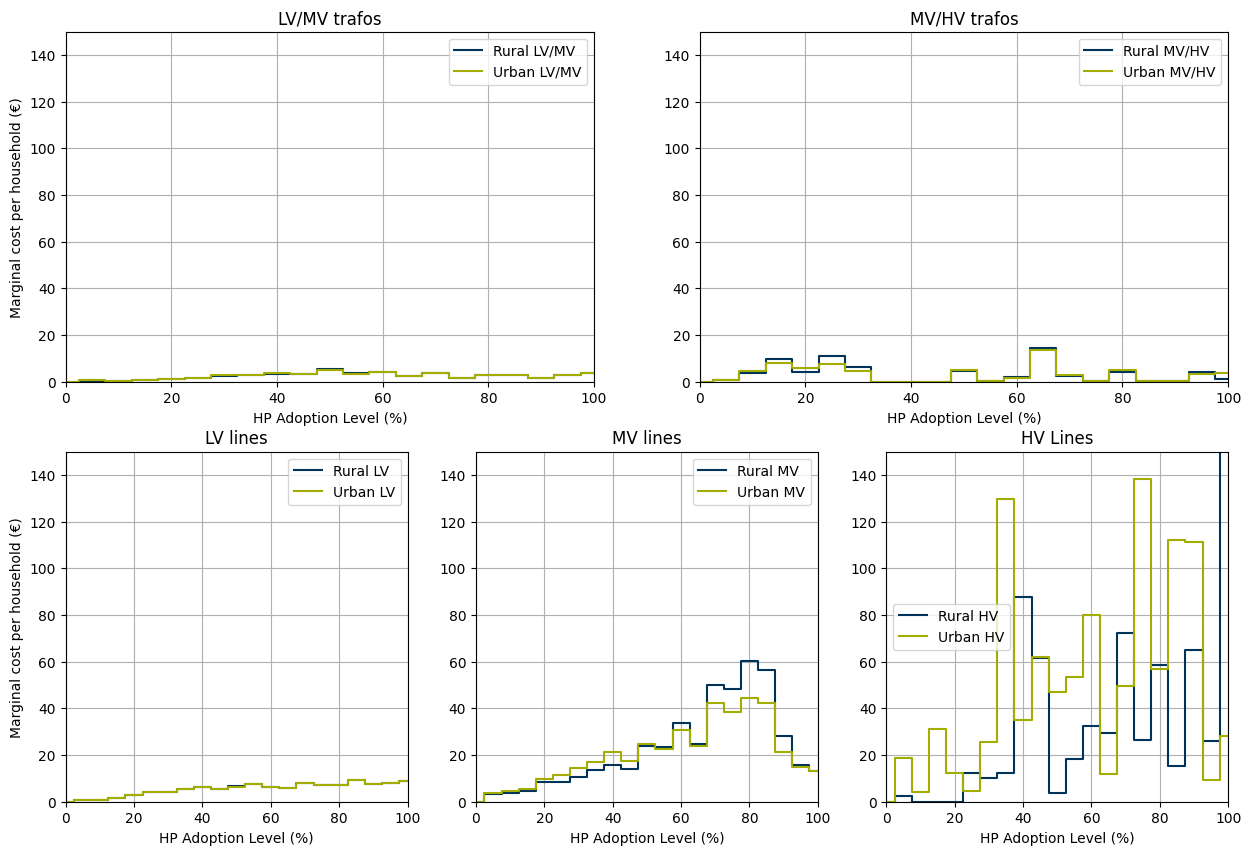

In [8]:
fig = plt.figure(figsize=(15, 10))

# Plot for transformers (upper subplot)
hv_data_rural = hv_data[hv_data['grid_code'] == 'HV-mixed']
hv_data_urban = hv_data[hv_data['grid_code'] == 'HV-urban']

# Calculate average trafo cost rural
rural_trafo_data = hv_data_rural.groupby('HP_percentage').agg({
    'total_households': 'mean',
    'LV_inc_trafo_reinforcement_cost': 'mean',
    'MV_inc_trafo_reinforcement_cost': 'mean',
}).reset_index()

rural_trafo_data['LV_inc_trafo_cost_per_household'] = (rural_trafo_data['LV_inc_trafo_reinforcement_cost'] / rural_trafo_data['total_households'])
rural_trafo_data['MV_inc_trafo_cost_per_household'] = (rural_trafo_data['MV_inc_trafo_reinforcement_cost'] / rural_trafo_data['total_households'])

# Calculate average trafo cost urban
urban_trafo_data = hv_data_urban.groupby('HP_percentage').agg({
    'total_households': 'mean',
    'LV_inc_trafo_reinforcement_cost': 'mean',
    'MV_inc_trafo_reinforcement_cost': 'mean',
}).reset_index()

urban_trafo_data['LV_inc_trafo_cost_per_household'] = (urban_trafo_data['LV_inc_trafo_reinforcement_cost'] / urban_trafo_data['total_households'])
urban_trafo_data['MV_inc_trafo_cost_per_household'] = (urban_trafo_data['MV_inc_trafo_reinforcement_cost'] / urban_trafo_data['total_households'])

# Calculate average line cost rural
rural_line_data = hv_data_rural.groupby('HP_percentage').agg({
    'total_households': 'mean',
    'LV_inc_line_reinforcement_cost': 'mean',
    'MV_inc_line_reinforcement_cost': 'mean',
    'HV_inc_line_reinforcement_cost': 'mean'
}).reset_index()

rural_line_data['LV_inc_line_cost_per_household'] = (rural_line_data['LV_inc_line_reinforcement_cost'] / rural_line_data['total_households'])
rural_line_data['MV_inc_line_cost_per_household'] = (rural_line_data['MV_inc_line_reinforcement_cost'] / rural_line_data['total_households'])
rural_line_data['HV_inc_line_cost_per_household'] = (rural_line_data['HV_inc_line_reinforcement_cost'] / rural_line_data['total_households'])

# Calculate average line cost urban
urban_line_data = hv_data_urban.groupby('HP_percentage').agg({
    'total_households': 'mean',
    'LV_inc_line_reinforcement_cost': 'mean',
    'MV_inc_line_reinforcement_cost': 'mean',
    'HV_inc_line_reinforcement_cost': 'mean'
}).reset_index()

urban_line_data['LV_inc_line_cost_per_household'] = (urban_line_data['LV_inc_line_reinforcement_cost'] / urban_line_data['total_households'])
urban_line_data['MV_inc_line_cost_per_household'] = (urban_line_data['MV_inc_line_reinforcement_cost'] / urban_line_data['total_households'])
urban_line_data['HV_inc_line_cost_per_household'] = (urban_line_data['HV_inc_line_reinforcement_cost'] / urban_line_data['total_households'])

# First row: Transformer plots
ax1 = plt.subplot(2, 2, 1)  # Rural transformers
ax2 = plt.subplot(2, 2, 2)  # Urban transformers

# Second row: Line plots
ax3 = plt.subplot(2, 3, 4)  # Rural lines LV
ax4 = plt.subplot(2, 3, 5)  # Rural lines MV
ax5 = plt.subplot(2, 3, 6)  # Rural lines HV

y_max = 150

# Plot transformer data for rural and urban grids
ax1.step(rural_trafo_data['HP_percentage'], rural_trafo_data['LV_inc_trafo_cost_per_household'], 
         where='mid', color='#003359', linestyle='-', label='Rural LV/MV')
ax1.step(urban_trafo_data['HP_percentage'], urban_trafo_data['LV_inc_trafo_cost_per_household'], 
         where='mid', color='#A2AD00', linestyle='-', label='Urban LV/MV')
ax1.set_title('LV/MV trafos')
ax1.set_xlabel('HP Adoption Level (%)')
ax1.set_ylabel('Marginal cost per household (€)')
ax1.grid(True)
ax1.legend()
ax1.set_ylim(0, y_max)  # Set same y-axis limit for transformer plots
ax1.set_xlim(0, 100)

ax2.step(rural_trafo_data['HP_percentage'], rural_trafo_data['MV_inc_trafo_cost_per_household'], 
         where='mid', color='#003359', linestyle='-', label='Rural MV/HV')
ax2.step(urban_trafo_data['HP_percentage'], urban_trafo_data['MV_inc_trafo_cost_per_household'], 
         where='mid', color='#A2AD00', linestyle='-', label='Urban MV/HV')
ax2.set_title('MV/HV trafos')
ax2.set_xlabel('HP Adoption Level (%)')
# ax2.set_ylabel('Marginal cost per household (€)')
ax2.grid(True)
ax2.legend()
ax2.set_ylim(0, y_max)  # Set same y-axis limit for transformer plots
ax2.set_xlim(0, 100)

# Plot line data
ax3.step(rural_line_data['HP_percentage'], rural_line_data['LV_inc_line_cost_per_household'], 
         where='mid', color='#003359', label='Rural LV')
ax3.step(urban_line_data['HP_percentage'], urban_line_data['LV_inc_line_cost_per_household'], 
         where='mid', color='#A2AD00', label='Urban LV')
ax3.set_title('LV lines')
ax3.set_xlabel('HP Adoption Level (%)')
ax3.set_ylabel('Marginal cost per household (€)')
ax3.grid(True)
ax3.legend()
ax3.set_ylim(0, y_max)  # Set same y-axis limit for line plots
ax3.set_xlim(0, 100)

ax4.step(rural_line_data['HP_percentage'], rural_line_data['MV_inc_line_cost_per_household'], 
         where='mid', color='#003359', label='Rural MV')
ax4.step(urban_line_data['HP_percentage'], urban_line_data['MV_inc_line_cost_per_household'], 
         where='mid', color='#A2AD00', label='Urban MV')
ax4.set_title('MV lines')
ax4.set_xlabel('HP Adoption Level (%)')
# ax4.set_ylabel('Marginal cost per household (€)')
ax4.grid(True)
ax4.legend()
ax4.set_ylim(0, y_max)  # Set same y-axis limit for line plots
ax4.set_xlim(0, 100)

ax5.step(rural_line_data['HP_percentage'], rural_line_data['HV_inc_line_cost_per_household'], 
         where='mid', color='#003359', label='Rural HV')
ax5.step(urban_line_data['HP_percentage'], urban_line_data['HV_inc_line_cost_per_household'], 
         where='mid', color='#A2AD00', label='Urban HV')
ax5.set_title('HV Lines')
ax5.set_xlabel('HP Adoption Level (%)')
# ax5.set_ylabel('Marginal cost per household (€)')
ax5.grid(True)
ax5.legend()
ax5.set_ylim(0, y_max)  # Set same y-axis limit for line plots
ax5.set_xlim(0, 100)

plt.tight_layout()
plt.show()

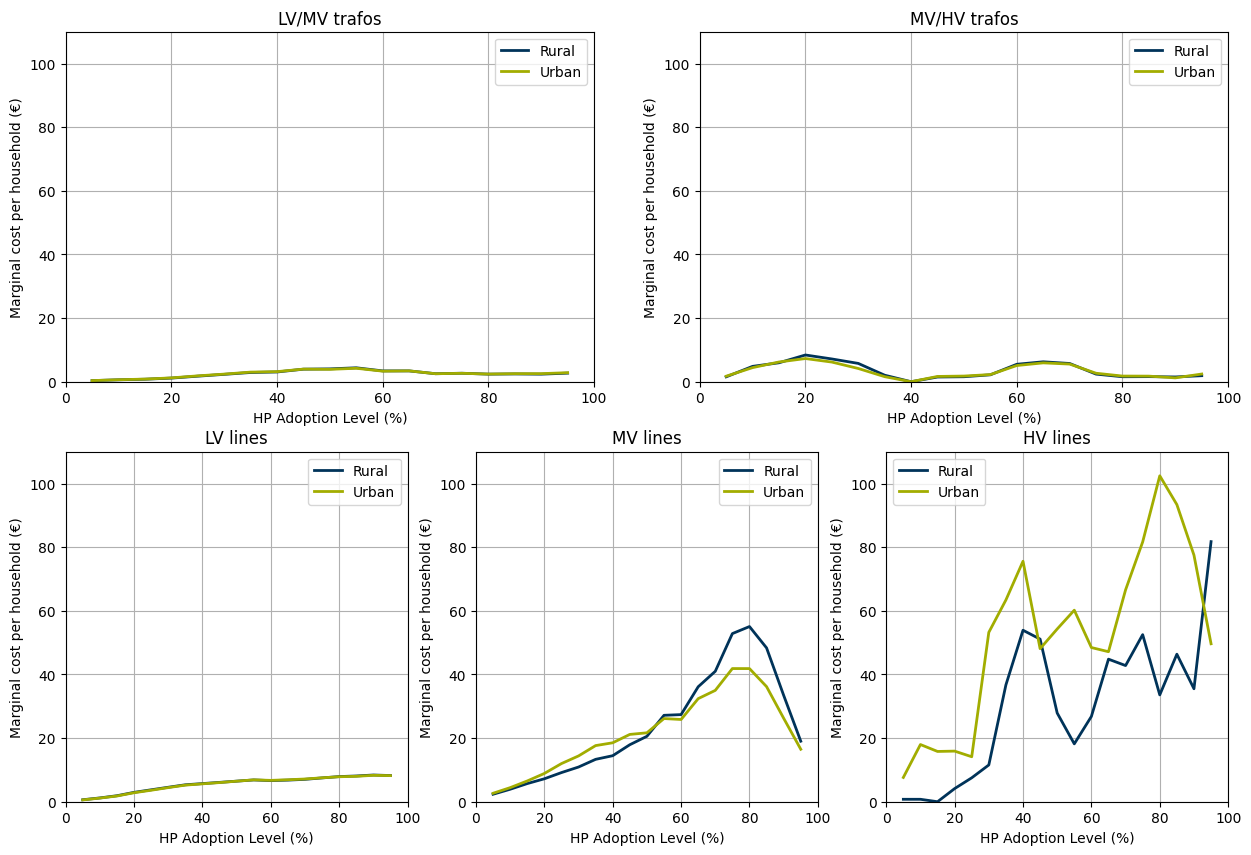

In [9]:
fig = plt.figure(figsize=(15, 10))

# First row: Transformer plots
ax1 = plt.subplot(2, 2, 1)  # Rural transformers
ax2 = plt.subplot(2, 2, 2)  # Urban transformers

# Second row: Line plots
ax3 = plt.subplot(2, 3, 4)  # Rural lines LV
ax4 = plt.subplot(2, 3, 5)  # Rural lines MV
ax5 = plt.subplot(2, 3, 6)  # Rural lines HV

y_max = 110

def plot_with_rolling_avg(ax, x, y, color, label, title, window=3):
    # Plot original data
    # ax.plot(x, y, color=color, alpha=0.3, linestyle='--', label=f'{label} (Raw)')
    
    # Calculate and plot rolling average
    rolling_avg = pd.Series(y).rolling(window=window, center=True).mean()
    ax.plot(x, rolling_avg, color=color, linewidth=2, label=f'{label}')
    ax.set_title(title)
    ax.set_xlabel('HP Adoption Level (%)')
    ax.set_ylabel('Marginal cost per household (€)')
    ax.grid(True)
    ax.legend()
    ax.set_ylim(0, y_max)
    ax.set_xlim(0, 100)

# Plot transformer data for rural and urban grids with rolling averages
plot_with_rolling_avg(ax1, rural_trafo_data['HP_percentage'], rural_trafo_data['LV_inc_trafo_cost_per_household'], 
                     '#003359', 'Rural', 'LV/MV trafos')
plot_with_rolling_avg(ax1, urban_trafo_data['HP_percentage'], urban_trafo_data['LV_inc_trafo_cost_per_household'], 
                     '#A2AD00', 'Urban', 'LV/MV trafos')

plot_with_rolling_avg(ax2, rural_trafo_data['HP_percentage'], rural_trafo_data['MV_inc_trafo_cost_per_household'], 
                     '#003359', 'Rural', 'MV/HV trafos')
plot_with_rolling_avg(ax2, urban_trafo_data['HP_percentage'], urban_trafo_data['MV_inc_trafo_cost_per_household'], 
                     '#A2AD00', 'Urban', 'MV/HV trafos')

# Plot line data with rolling averages
plot_with_rolling_avg(ax3, rural_line_data['HP_percentage'], rural_line_data['LV_inc_line_cost_per_household'], 
                     '#003359', 'Rural', 'LV lines')
plot_with_rolling_avg(ax3, urban_line_data['HP_percentage'], urban_line_data['LV_inc_line_cost_per_household'], 
                     '#A2AD00', 'Urban', 'LV lines')

plot_with_rolling_avg(ax4, rural_line_data['HP_percentage'], rural_line_data['MV_inc_line_cost_per_household'], 
                     '#003359', 'Rural', 'MV lines')
plot_with_rolling_avg(ax4, urban_line_data['HP_percentage'], urban_line_data['MV_inc_line_cost_per_household'], 
                     '#A2AD00', 'Urban', 'MV lines')

plot_with_rolling_avg(ax5, rural_line_data['HP_percentage'], rural_line_data['HV_inc_line_cost_per_household'], 
                     '#003359', 'Rural', 'HV lines')
plot_with_rolling_avg(ax5, urban_line_data['HP_percentage'], urban_line_data['HV_inc_line_cost_per_household'], 
                     '#A2AD00', 'Urban', 'HV lines')

In [10]:
rural_output = hv_mixed_data.copy()
rural_output['grid_type'] = 'Distribution Grid - rural'

# Group and aggregate correctly
rural_output = rural_output.groupby('HP_percentage').agg({
    'total_households': 'mean',
    'total_reinforcement_cost': 'mean',
    'LV_total_reinforcement_cost': 'mean',
    'LV_total_trafo_reinforcement_cost': 'mean', 
    'LV_total_line_reinforcement_cost': 'mean',
    'MV_total_reinforcement_cost': 'mean', 
    'MV_total_trafo_reinforcement_cost': 'mean',
    'MV_total_line_reinforcement_cost': 'mean',
    'HV_total_reinforcement_cost': 'mean',
    'HV_total_line_reinforcement_cost': 'mean'}).reset_index()

# Divide all columns (except 'HP_percentage' and 'total_households') by 'total_households'
columns_to_divide = [col for col in rural_output.columns if col not in ['HP_percentage', 'total_households']]
for col in columns_to_divide:
    rural_output[f"{col}_per_hh"] = rural_output[col] / rural_output['total_households']

# Drop original columns if desired (excluding HP_percentage and total_households)
rural_output = rural_output[['HP_percentage', 'total_households'] + [f"{col}_per_hh" for col in columns_to_divide]]

urban_output = hv_urban_data.copy()
urban_output['grid_type'] = 'Distribution Grid - rural'

# Group and aggregate correctly
urban_output = urban_output.groupby('HP_percentage').agg({
    'total_households': 'mean',
    'total_reinforcement_cost': 'mean',
    'LV_total_reinforcement_cost': 'mean',
    'LV_total_trafo_reinforcement_cost': 'mean', 
    'LV_total_line_reinforcement_cost': 'mean',
    'MV_total_reinforcement_cost': 'mean', 
    'MV_total_trafo_reinforcement_cost': 'mean',
    'MV_total_line_reinforcement_cost': 'mean',
    'HV_total_reinforcement_cost': 'mean',
    'HV_total_line_reinforcement_cost': 'mean'}).reset_index()

# Divide all columns (except 'HP_percentage' and 'total_households') by 'total_households'
columns_to_divide = [col for col in urban_output.columns if col not in ['HP_percentage', 'total_households']]
for col in columns_to_divide:
    urban_output[f"{col}_per_hh"] = urban_output[col] / urban_output['total_households']

# Drop original columns if desired (excluding HP_percentage and total_households)
urban_output = urban_output[['HP_percentage', 'total_households'] + [f"{col}_per_hh" for col in columns_to_divide]]

# Add grid_code to each DataFrame
rural_output['grid_code'] = 'Distribution Grid - rural'
urban_output['grid_code'] = 'Distribution Grid - urban'

# Combine the DataFrames
combined_output = pd.concat([rural_output, urban_output], ignore_index=True)

In [11]:
# Split the data by grid code
rural_costs = combined_output[combined_output['grid_code'] == 'Distribution Grid - rural'][
    ['HP_percentage',
     'LV_total_trafo_reinforcement_cost_per_hh',
     'MV_total_trafo_reinforcement_cost_per_hh',
     'LV_total_line_reinforcement_cost_per_hh',
     'MV_total_line_reinforcement_cost_per_hh',
     'HV_total_line_reinforcement_cost_per_hh'
    ]]

urban_costs = combined_output[combined_output['grid_code'] == 'Distribution Grid - urban'][
    ['HP_percentage',
     'LV_total_trafo_reinforcement_cost_per_hh',
     'MV_total_trafo_reinforcement_cost_per_hh',
     'LV_total_line_reinforcement_cost_per_hh',
     'MV_total_line_reinforcement_cost_per_hh',
     'HV_total_line_reinforcement_cost_per_hh'
    ]]

# Add a blank column between specified columns for rural costs
cols = list(rural_costs.columns)
insert_pos = cols.index('LV_total_line_reinforcement_cost_per_hh')
rural_costs.insert(insert_pos, 'blank', 0.000001)

# Add a blank column between specified columns for urban costs
cols = list(urban_costs.columns)
insert_pos = cols.index('LV_total_line_reinforcement_cost_per_hh') 
urban_costs.insert(insert_pos, 'blank', 0.000001)

# Drop the rows with HP_percentage = 0 from both rural and urban costs
rural_costs = rural_costs[rural_costs['HP_percentage'] != 0]
urban_costs = urban_costs[urban_costs['HP_percentage'] != 0]

# Transpose the dataframes to have HP percentages as columns
rural_costs_t = rural_costs.transpose()
urban_costs_t = urban_costs.transpose()

# Use HP_percentage as column names
rural_costs_t.columns = rural_costs_t.loc['HP_percentage']
urban_costs_t.columns = urban_costs_t.loc['HP_percentage']

# Drop the HP_percentage row since it's now used as column names
rural_costs_t = rural_costs_t.drop('HP_percentage')
urban_costs_t = urban_costs_t.drop('HP_percentage')

In [12]:
rural_costs_t

HP_percentage,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0,90.0,95.0,100.0
LV_total_trafo_reinforcement_cost_per_hh,0.518946,1.019572,1.807651,2.868192,4.437021,7.038745,9.818337,13.136193,16.232882,21.652835,25.243155,29.372739,31.850223,35.453866,36.923435,39.852915,42.608525,44.263289,46.984258,50.698152
MV_total_trafo_reinforcement_cost_per_hh,0.814059,4.602564,14.480856,18.676391,29.807081,35.943833,35.943833,35.943833,35.943833,40.374193,40.640327,42.456305,56.827576,59.426303,59.661128,63.997557,64.122797,64.467206,68.490536,69.805554
blank,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
LV_total_line_reinforcement_cost_per_hh,0.933330,1.851306,3.567007,6.582383,10.675066,14.804773,20.211066,26.637883,31.901506,38.444589,46.037686,52.437847,58.356570,66.411138,73.549990,80.807012,90.119685,97.821030,105.995563,114.801349
MV_total_line_reinforcement_cost_per_hh,3.130543,7.040604,11.755098,20.224382,28.663695,39.211714,52.927275,68.624656,82.599816,106.666030,130.302725,164.077038,188.810720,238.687792,287.058315,347.340905,403.842825,432.079005,447.639176,460.904559
HV_total_line_reinforcement_cost_per_hh,2.294692,2.294692,2.294692,2.294692,14.668199,24.831370,36.961087,124.826979,186.501981,190.287218,208.448319,241.063228,270.708091,342.855960,369.440260,428.237749,443.587921,508.542827,534.752070,688.813659


In [13]:
urban_costs_t

HP_percentage,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0,90.0,95.0,100.0
LV_total_trafo_reinforcement_cost_per_hh,0.557213,1.062979,1.878182,3.029301,4.677108,7.399999,10.198168,13.747610,16.907041,22.094076,25.419574,29.582972,32.058465,35.662001,37.113100,39.997140,42.873614,44.678409,47.612761,51.392578
MV_total_trafo_reinforcement_cost_per_hh,0.728954,5.209354,13.298965,19.343949,27.060193,31.825063,31.825063,31.825063,31.825063,36.803285,37.158873,38.563442,52.075760,54.938238,55.204928,60.076474,60.272047,60.467620,63.703464,67.526028
blank,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
LV_total_line_reinforcement_cost_per_hh,0.864479,1.735234,3.419728,6.252964,10.214207,14.233910,19.564101,25.858553,31.100836,37.616115,45.216962,51.713911,57.748183,65.914589,73.142815,80.300621,89.464314,97.097985,105.192377,114.072346
MV_total_line_reinforcement_cost_per_hh,3.525822,7.967160,13.264019,23.088329,34.609092,49.209613,66.253880,87.530514,104.782604,129.705112,152.507761,183.203085,207.241619,249.686788,288.192459,332.792495,375.211170,396.701882,411.478993,424.671229
HV_total_line_reinforcement_cost_per_hh,18.745657,22.889448,53.915794,66.146674,70.603114,96.326613,225.855776,260.829501,323.057283,370.165827,423.697377,503.644155,515.531900,565.141162,703.402677,760.484707,872.439452,983.549339,992.969906,1021.349072


# 1b: Urban vs. rural

In [14]:
# Define the original grid codes
original_grid_codes = ["1-HV-mixed--0-no_sw", "1-HV-urban--0-no_sw"]

# Clean the grid codes by removing the first 2 characters and the last 9 characters
cleaned_grid_codes = [code[2:-9] for code in original_grid_codes]

# Initialize an empty list to store DataFrames
line_lengths_list = []

# Calculate the average number of households for each cleaned grid code in results_df
households_summary = results_df[results_df['grid_code'].isin(cleaned_grid_codes)].groupby('grid_code')['total_households'].mean().reset_index()
households_summary.rename(columns={'total_households': 'average_total_households'}, inplace=True)

for code, cleaned_code in zip(original_grid_codes, cleaned_grid_codes):
    # Get the network for each original grid code
    net = sb.get_simbench_net(code)
    
    # Group by 'type' and sum the 'length_km'
    line_lengths = net.line.groupby('type')['length_km'].sum().to_frame()
    
    # Calculate the total length for this grid code
    total_length = line_lengths['length_km'].sum()
    
    # Calculate the percentage of each line type's length
    line_lengths['percentage'] = (line_lengths['length_km'] / total_length) * 100
    
    # Add columns for the cleaned grid code and total line length
    line_lengths['grid_code'] = cleaned_code  # Use cleaned code here
    line_lengths['total_length'] = total_length
    
    # Append to the list
    line_lengths_list.append(line_lengths)

# Concatenate all results into a single DataFrame
combined_line_lengths = pd.concat(line_lengths_list).reset_index()

# Merge with households_summary to add the average total households for each grid code
combined_line_lengths = combined_line_lengths.merge(households_summary, on='grid_code', how='left')

combined_line_lengths["km_line_per_household"] = combined_line_lengths["total_length"] / combined_line_lengths["average_total_households"]

# Display the final DataFrame
combined_line_lengths [["grid_code", "type", "length_km", "percentage", "km_line_per_household"]]

,grid_code,type,length_km,percentage,km_line_per_household
0,HV-mixed,cs,1.438850,0.132789,0.003609
1,HV-mixed,ol,1082.125857,99.867211,0.003609
2,HV-urban,cs,118.805461,15.806938,0.002843
3,HV-urban,ol,632.797804,84.193062,0.002843


# 2a: Network tariff increase - 60% HP discount

In [33]:
current_tariff = 11.53

# Filter data for HV level only
hv_data = results_df[results_df['grid_level'] == 'HV']

# Total number of households (mean over all runs)
total_households = hv_data['total_households'].mean()

# Average household consumption without HP
average_consumption_HH = hv_data['HH_total_kWh_consumed'].mean() / total_households

# Average household HP consumption if HP installed
average_consumption_HP = (
    hv_data[hv_data['HP_percentage'] == 100]['HP_total_kWh_consumed'].mean()
    / total_households
)

structured_table_rows = []

grid_names = {
    "HV-urban": "Distribution Grid - urban",
    "HV-mixed": "Distribution Grid - rural"
}

# store base costs per grid so increases are computed correctly
base_cost_without_hp = {}
base_cost_with_hp = {}

for hp_percentage in sorted(hv_data['HP_percentage'].unique()):
    for grid_code, grid_name in grid_names.items():
        # Filter data for this grid and HP level
        grid_data = hv_data[
            (hv_data['grid_code'] == grid_code) &
            (hv_data['HP_percentage'] == hp_percentage)
        ]

        # Number of households
        number_of_households = grid_data['total_households'].mean()
        num_hp_households = grid_data['total_households_HP'].mean()

        # Tariffs
        extra_tariff = grid_data['tariff_ct_with_HP_discount'].mean()
        total_tariff = current_tariff + extra_tariff
        total_tariff_HP = total_tariff * (1 - hp_tariff_discount)

        # Costs
        cost_without_hp = (total_tariff / 100) * average_consumption_HH
        cost_with_hp = cost_without_hp + (total_tariff_HP / 100) * average_consumption_HP

        # Set base costs at 0% HP adoption (per grid)
        if hp_percentage == 0:
            base_cost_without_hp[grid_name] = cost_without_hp
            base_cost_with_hp[grid_name] = cost_with_hp

        # Cost increases relative to base
        increase_without_hp_euros = cost_without_hp - base_cost_without_hp[grid_name]
        increase_without_hp_percentage = (
            increase_without_hp_euros / base_cost_without_hp[grid_name] * 100
        )

        increase_with_hp_euros = cost_with_hp - base_cost_with_hp[grid_name]
        increase_with_hp_percentage = (
            increase_with_hp_euros / base_cost_with_hp[grid_name] * 100
        )

        # Now we make ONE row per (grid_name, hp_percentage)
        row = {
            'grid_name': grid_name,
            'HP_percentage': hp_percentage,
            'Number of households': number_of_households,
            'Number of HP households': num_hp_households,
            'Average HH consumption (kWh)': average_consumption_HH,
            'Average HP consumption (kWh)': average_consumption_HP,
            'Base tariff (ct/kWh)': current_tariff,
            'Extra tariff (ct/kWh)': extra_tariff,
            'Cost (HH w/o HP) (€)': cost_without_hp,
            'Cost increase (HH w/o HP) (€)': increase_without_hp_euros,
            'Cost increase (HH w/o HP) (%)': increase_without_hp_percentage,
            'Cost (HH with HP) (€)': cost_with_hp,
            'Cost increase (HH with HP) (€)': increase_with_hp_euros,
            'Cost increase (HH with HP) (%)': increase_with_hp_percentage,
        }

        structured_table_rows.append(row)

# Simple flat DataFrame now
structured_table = pd.DataFrame(structured_table_rows).sort_values(by=['grid_name', 'HP_percentage'])

pd.options.display.float_format = '{:.4f}'.format
structured_table

,grid_name,HP_percentage,Number of households,Number of HP households,Average HH consumption (kWh),Average HP consumption (kWh),Base tariff (ct/kWh),Extra tariff (ct/kWh),Cost (HH w/o HP) (€),Cost increase (HH w/o HP) (€),Cost increase (HH w/o HP) (%),Cost (HH with HP) (€),Cost increase (HH with HP) (€),Cost increase (HH with HP) (%)
1,Distribution Grid - rural,0,300223.9600,0.0000,2645.7488,4401.3086,11.5300,0.0000,305.0548,0.0000,0.0000,508.0432,0.0000,0.0000
3,Distribution Grid - rural,5,300223.9600,12732.4500,2645.7488,4401.3086,11.5300,0.0209,305.6071,0.5522,0.1810,508.9629,0.9197,0.1810
5,Distribution Grid - rural,10,300223.9600,27903.8600,2645.7488,4401.3086,11.5300,0.0450,306.2460,1.1912,0.3905,510.0270,1.9838,0.3905
7,Distribution Grid - rural,15,300223.9600,40922.9300,2645.7488,4401.3086,11.5300,0.0899,307.4330,2.3782,0.7796,512.0039,3.9607,0.7796
9,Distribution Grid - rural,20,300223.9600,57856.9900,2645.7488,4401.3086,11.5300,0.1290,308.4670,3.4122,1.1186,513.7259,5.6827,1.1186
11,Distribution Grid - rural,25,300223.9600,72530.7700,2645.7488,4401.3086,11.5300,0.2174,310.8075,5.7527,1.8858,517.6238,9.5806,1.8858
13,Distribution Grid - rural,30,300223.9600,86973.7100,2645.7488,4401.3086,11.5300,0.2910,312.7530,7.6981,2.5235,520.8638,12.8206,2.5235
15,Distribution Grid - rural,35,300223.9600,103194.3500,2645.7488,4401.3086,11.5300,0.3587,314.5463,9.4914,3.1114,523.8504,15.8072,3.1114
17,Distribution Grid - rural,40,300223.9600,118934.5300,2645.7488,4401.3086,11.5300,0.5946,320.7853,15.7305,5.1566,534.2410,26.1978,5.1566
19,Distribution Grid - rural,45,300223.9600,132147.4400,2645.7488,4401.3086,11.5300,0.7595,325.1488,20.0940,6.5870,541.5080,33.4648,6.5870


In [34]:
# Calculate data for output table
output_table = structured_table[["grid_name", "HP_percentage", "Number of households", "Number of HP households", "Average HH consumption (kWh)", "Average HP consumption (kWh)", "Extra tariff (ct/kWh)"]].copy()
output_table = output_table[output_table["HP_percentage"].isin(range(5, 101, 5))]
output_table["total_tariff_volume"] = (output_table["Number of households"] * output_table["Average HH consumption (kWh)"] * output_table["Extra tariff (ct/kWh)"] + 
                                       output_table["Number of HP households"] * output_table["Average HP consumption (kWh)"] * output_table["Extra tariff (ct/kWh)"] * (1 - hp_tariff_discount)) / 100
output_table["tariff_volume_HHwoHP_HH"] = (output_table["Number of households"] - output_table["Number of HP households"])* output_table["Average HH consumption (kWh)"] * output_table["Extra tariff (ct/kWh)"] / 100
output_table["tariff_volume_HHwHP_HH"] = output_table["Number of HP households"]* output_table["Average HH consumption (kWh)"] * output_table["Extra tariff (ct/kWh)"] / 100
output_table["tariff_volume_HHwHP_HP"] = output_table["Number of HP households"]* output_table["Average HP consumption (kWh)"] * output_table["Extra tariff (ct/kWh)"] * (1 - hp_tariff_discount) / 100
df = output_table[[
    "HP_percentage", "grid_name", "total_tariff_volume",
    "tariff_volume_HHwoHP_HH", "tariff_volume_HHwHP_HH",
    "tariff_volume_HHwHP_HP"
]]

# Set HP_percentage as the index first
df = df.set_index("HP_percentage")

# Transpose → HP_percentage becomes the column headers
df_t = df.T

df_t


HP_percentage,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100
grid_name,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban
total_tariff_volume,170470.6371,379730.6837,778749.8708,1155787.2973,2004738.9250,2756687.4850,3501304.7286,5967590.6967,7799617.8191,8786603.4027,9951623.5707,11675471.7123,13397669.6746,16374615.6959,18195832.0431,21113556.0440,22946067.8731,25182146.6118,26430193.7547,30375030.7229,470638.0937,759011.3077,1676887.1780,2307749.1892,2889664.5353,3898955.5970,6863207.7288,8137004.8989,9826042.4900,11549364.7039,13233851.1017,15593548.7132,16743939.9603,18802087.0758,22358435.3187,24606433.7892,27801964.0692,30527080.7364,31277013.3240,32405964.2336
tariff_volume_HHwoHP_HH,158760.7473,324375.8206,616667.3583,827002.3822,1309848.8068,1641631.2380,1870092.9760,2851769.1908,3377325.9415,3326700.9055,3357127.8309,3430092.3539,3476100.8482,3470191.4132,3172273.2374,2898141.1688,2270213.9776,1697018.2829,982602.2599,0.0000,438253.6310,648068.3316,1328477.5674,1653134.6653,1888226.1166,2321998.5099,3675018.1042,3897534.5048,4258200.0556,4373300.6395,4464240.2295,4572169.3245,4333111.6575,3980374.5327,3878301.6058,3356455.1531,2738700.2635,2047981.5848,1150066.5413,0.0000
tariff_volume_HHwHP_HH,7031.2103,33237.8605,97322.5410,197419.0978,417247.1849,669536.1868,979462.0672,1870896.8767,2655367.7885,3278401.7023,3959668.8897,4950942.9405,5957411.9037,7748469.2368,9020904.8217,10937456.6973,12414828.7707,14101659.2754,15280021.4507,18238705.2663,19445.2699,66615.7760,209202.7579,393063.6803,601314.2942,946884.8210,1914350.3566,2545592.5200,3343214.3018,4308871.9362,5265718.0649,6617793.8101,7452089.2371,8899706.1133,11096407.2810,12759562.3127,15049251.6611,17100292.0265,18089743.1168,19458180.5009
tariff_volume_HHwHP_HP,4678.6795,22117.0026,64759.9715,131365.8172,277642.9334,445520.0602,651749.6854,1244924.6293,1766924.0891,2181500.7949,2634826.8501,3294436.4178,3964156.9227,5155955.0459,6002653.9840,7277958.1779,8261025.1248,9383469.0536,10167570.0441,12136325.4566,12939.1928,44327.2001,139206.8527,261550.8436,400124.1245,630072.2661,1273839.2680,1693877.8741,2224628.1326,2867192.1282,3503892.8073,4403585.5786,4958739.0657,5922006.4298,7383726.4320,8490416.3234,10014012.1446,11378807.1251,12037203.6659,12947783.7327


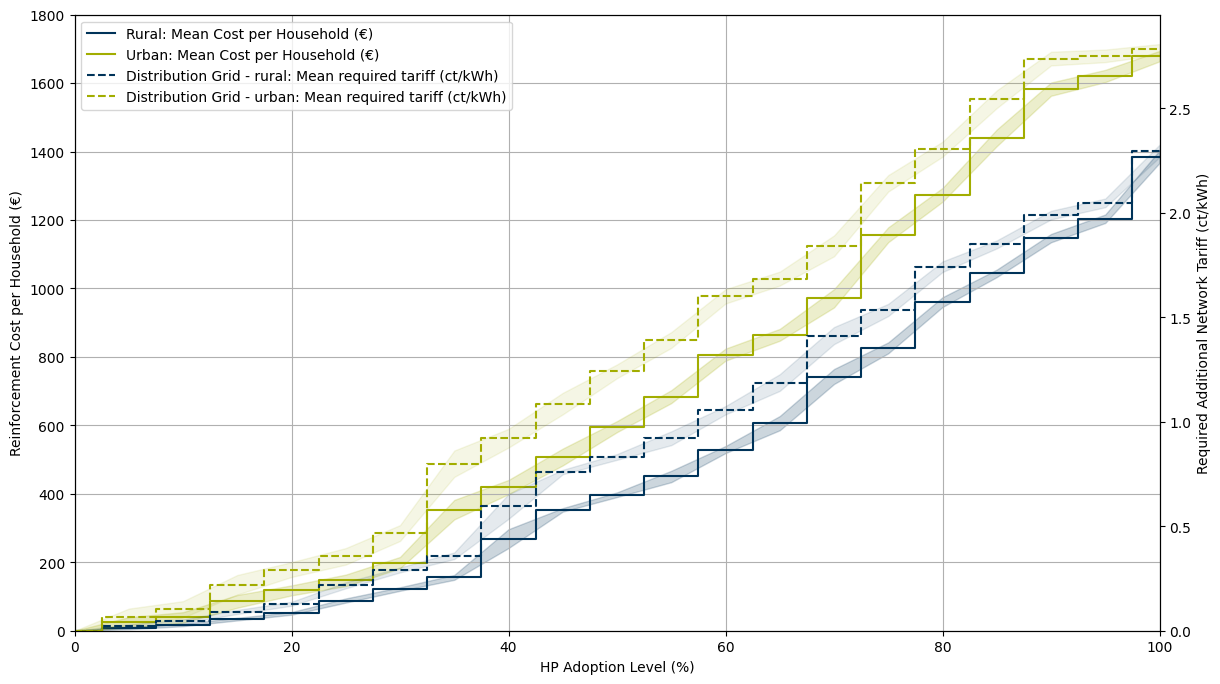

In [35]:
import matplotlib.pyplot as plt

def plot_combined_dual_axis(results_df, hv_mixed_summary, hv_urban_summary):
    # --- Filter for HV data ---
    hv_data = results_df[results_df['grid_level'] == 'HV']
    colors_and_labels = [
        {'color': '#003359', 'label': 'Distribution Grid - rural'},
        {'color': '#A2AD00', 'label': 'Distribution Grid - urban'}
    ]

    # --- Create figure and dual axes ---
    fig, ax1 = plt.subplots(figsize=(14, 8))
    ax2 = ax1.twinx()  # second y-axis

    # ------------------------
    # Left y-axis → Cost per Household
    # ------------------------
    ax1.step(hv_mixed_summary['HP_percentage'], hv_mixed_summary['mean'], where='mid',
             color='#003359', linestyle='-', label='Rural: Mean Cost per Household (€)')
    ax1.fill_between(hv_mixed_summary['HP_percentage'],
                     hv_mixed_summary['mean'] - hv_mixed_summary['std'],
                     hv_mixed_summary['mean'] + hv_mixed_summary['std'],
                     color='#003359', alpha=0.2)

    ax1.step(hv_urban_summary['HP_percentage'], hv_urban_summary['mean'], where='mid',
             color='#A2AD00', linestyle='-', label='Urban: Mean Cost per Household (€)')
    ax1.fill_between(hv_urban_summary['HP_percentage'],
                     hv_urban_summary['mean'] - hv_urban_summary['std'],
                     hv_urban_summary['mean'] + hv_urban_summary['std'],
                     color='#A2AD00', alpha=0.2)

    ax1.set_ylabel("Reinforcement Cost per Household (€)", color="black")
    ax1.set_ylim(0, 1800)

    # ------------------------
    # Right y-axis → Tariff (ct/kWh)
    # ------------------------
    for i, grid_code in enumerate(hv_data['grid_code'].unique()):
        grid_data = hv_data[hv_data['grid_code'] == grid_code]

        hp_adoption_levels = []
        required_tariffs_mean = []
        required_tariffs_std = []

        for hp_percentage in sorted(grid_data['HP_percentage'].unique()):
            hp_data = grid_data[grid_data['HP_percentage'] == hp_percentage]
            tariff_mean = hp_data['tariff_ct_with_HP_discount'].mean()
            tariff_std = hp_data['tariff_ct_with_HP_discount'].std()

            hp_adoption_levels.append(hp_percentage)
            required_tariffs_mean.append(tariff_mean)
            required_tariffs_std.append(tariff_std)

        color_info = colors_and_labels[i % len(colors_and_labels)]
        ax2.step(hp_adoption_levels, required_tariffs_mean, where='mid',
                 color=color_info['color'], linestyle='--',
                 label=f"{color_info['label']}: Mean required tariff (ct/kWh)")
        ax2.fill_between(hp_adoption_levels,
                         [m - s for m, s in zip(required_tariffs_mean, required_tariffs_std)],
                         [m + s for m, s in zip(required_tariffs_mean, required_tariffs_std)],
                         color=color_info['color'], alpha=0.1)

    ax2.set_ylabel("Required Additional Network Tariff (ct/kWh)", color="black")
    ax2.set_ylim(0)  # starts at 0, auto upper bound

    # ------------------------
    # Formatting
    # ------------------------
    ax1.set_xlabel("HP Adoption Level (%)")
    ax1.set_xlim(0, 100)
    # fig.suptitle("Combined: Reinforcement Cost per Household & Required Additional Network Tariff")

    # Combine legends from both axes
    lines_labels_1 = ax1.get_legend_handles_labels()
    lines_labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_labels_1[0] + lines_labels_2[0],
               lines_labels_1[1] + lines_labels_2[1],
               loc="upper left")

    ax1.grid(True)
    plt.show()


# Call function
plot_combined_dual_axis(results_df, hv_mixed_summary, hv_urban_summary)


# 2: Network tariff increase - no discount

In [29]:
current_tariff = 11.53

# Filter data for HV level only
hv_data = results_df[results_df['grid_level'] == 'HV']

# Total number of households (mean over all runs)
total_households = hv_data['total_households'].mean()

# Average household consumption without HP
average_consumption_HH = hv_data['HH_total_kWh_consumed'].mean() / total_households

# Average household HP consumption if HP installed
average_consumption_HP = (
    hv_data[hv_data['HP_percentage'] == 100]['HP_total_kWh_consumed'].mean()
    / total_households
)

structured_table_rows = []

grid_names = {
    "HV-urban": "Distribution Grid - urban",
    "HV-mixed": "Distribution Grid - rural"
}

# store base costs per grid so increases are computed correctly
base_cost_without_hp = {}
base_cost_with_hp = {}

for hp_percentage in sorted(hv_data['HP_percentage'].unique()):
    for grid_code, grid_name in grid_names.items():
        # Filter data for this grid and HP level
        grid_data = hv_data[
            (hv_data['grid_code'] == grid_code) &
            (hv_data['HP_percentage'] == hp_percentage)
        ]

        # Number of households
        number_of_households = grid_data['total_households'].mean()
        num_hp_households = grid_data['total_households_HP'].mean()

        # Tariffs
        extra_tariff = grid_data['tariff_ct_without_HP_discount'].mean()
        total_tariff = current_tariff + extra_tariff
        total_tariff_HP = total_tariff

        # Costs
        cost_without_hp = (total_tariff / 100) * average_consumption_HH
        cost_with_hp = cost_without_hp + (total_tariff_HP / 100) * average_consumption_HP

        # Set base costs at 0% HP adoption (per grid)
        if hp_percentage == 0:
            base_cost_without_hp[grid_name] = cost_without_hp
            base_cost_with_hp[grid_name] = cost_with_hp

        # Cost increases relative to base
        increase_without_hp_euros = cost_without_hp - base_cost_without_hp[grid_name]
        increase_without_hp_percentage = (
            increase_without_hp_euros / base_cost_without_hp[grid_name] * 100
        )

        increase_with_hp_euros = cost_with_hp - base_cost_with_hp[grid_name]
        increase_with_hp_percentage = (
            increase_with_hp_euros / base_cost_with_hp[grid_name] * 100
        )

        # Now we make ONE row per (grid_name, hp_percentage)
        row = {
            'grid_name': grid_name,
            'HP_percentage': hp_percentage,
            'Number of households': number_of_households,
            'Number of HP households': num_hp_households,
            'Average HH consumption (kWh)': average_consumption_HH,
            'Average HP consumption (kWh)': average_consumption_HP,
            'Base tariff (ct/kWh)': current_tariff,
            'Extra tariff (ct/kWh)': extra_tariff,
            'Cost (HH w/o HP) (€)': cost_without_hp,
            'Cost increase (HH w/o HP) (€)': increase_without_hp_euros,
            'Cost increase (HH w/o HP) (%)': increase_without_hp_percentage,
            'Cost (HH with HP) (€)': cost_with_hp,
            'Cost increase (HH with HP) (€)': increase_with_hp_euros,
            'Cost increase (HH with HP) (%)': increase_with_hp_percentage,
        }

        structured_table_rows.append(row)

# Simple flat DataFrame now
structured_table = pd.DataFrame(structured_table_rows).sort_values(by=['grid_name', 'HP_percentage'])

pd.options.display.float_format = '{:.4f}'.format
structured_table

,grid_name,HP_percentage,Number of households,Number of HP households,Average HH consumption (kWh),Average HP consumption (kWh),Base tariff (ct/kWh),Extra tariff (ct/kWh),Cost (HH w/o HP) (€),Cost increase (HH w/o HP) (€),Cost increase (HH w/o HP) (%),Cost (HH with HP) (€),Cost increase (HH with HP) (€),Cost increase (HH with HP) (%)
1,Distribution Grid - rural,0,300223.9600,0.0000,2645.7488,4401.3086,11.5300,0.0000,305.0548,0.0000,0.0000,812.5257,0.0000,0.0000
3,Distribution Grid - rural,5,300223.9600,12732.4500,2645.7488,4401.3086,11.5300,0.0200,305.5853,0.5305,0.1739,813.9386,1.4129,0.1739
5,Distribution Grid - rural,10,300223.9600,27903.8600,2645.7488,4401.3086,11.5300,0.0414,306.1505,1.0957,0.3592,815.4442,2.9185,0.3592
7,Distribution Grid - rural,15,300223.9600,40922.9300,2645.7488,4401.3086,11.5300,0.0799,307.1691,2.1143,0.6931,818.1572,5.6315,0.6931
9,Distribution Grid - rural,20,300223.9600,57856.9900,2645.7488,4401.3086,11.5300,0.1102,307.9692,2.9144,0.9554,820.2884,7.7626,0.9554
11,Distribution Grid - rural,25,300223.9600,72530.7700,2645.7488,4401.3086,11.5300,0.1800,309.8164,4.7615,1.5609,825.2083,12.6826,1.5609
13,Distribution Grid - rural,30,300223.9600,86973.7100,2645.7488,4401.3086,11.5300,0.2341,311.2497,6.1949,2.0307,829.0260,16.5003,2.0307
15,Distribution Grid - rural,35,300223.9600,103194.3500,2645.7488,4401.3086,11.5300,0.2803,312.4714,7.4166,2.4312,832.2801,19.7544,2.4312
17,Distribution Grid - rural,40,300223.9600,118934.5300,2645.7488,4401.3086,11.5300,0.4527,317.0324,11.9776,3.9264,844.4284,31.9027,3.9264
19,Distribution Grid - rural,45,300223.9600,132147.4400,2645.7488,4401.3086,11.5300,0.5668,320.0503,14.9955,4.9157,852.4669,39.9411,4.9157


In [30]:
# Calculate data for output table
output_table = structured_table[["grid_name", "HP_percentage", "Number of households", "Number of HP households", "Average HH consumption (kWh)", "Average HP consumption (kWh)", "Extra tariff (ct/kWh)"]].copy()
output_table = output_table[output_table["HP_percentage"].isin(range(5, 101, 5))]
output_table["total_tariff_volume"] = (output_table["Number of households"] * output_table["Average HH consumption (kWh)"] * output_table["Extra tariff (ct/kWh)"] + 
                                       output_table["Number of HP households"] * output_table["Average HP consumption (kWh)"] * output_table["Extra tariff (ct/kWh)"]) / 100
output_table["tariff_volume_HHwoHP_HH"] = (output_table["Number of households"] - output_table["Number of HP households"])* output_table["Average HH consumption (kWh)"] * output_table["Extra tariff (ct/kWh)"] / 100
output_table["tariff_volume_HHwHP_HH"] = output_table["Number of HP households"]* output_table["Average HH consumption (kWh)"] * output_table["Extra tariff (ct/kWh)"] / 100
output_table["tariff_volume_HHwHP_HP"] = output_table["Number of HP households"]* output_table["Average HP consumption (kWh)"] * output_table["Extra tariff (ct/kWh)"] / 100
df = output_table[[
    "HP_percentage", "grid_name", "total_tariff_volume",
    "tariff_volume_HHwoHP_HH", "tariff_volume_HHwHP_HH",
    "tariff_volume_HHwHP_HP"
]]

# Set HP_percentage as the index first
df = df.set_index("HP_percentage")

# Transpose → HP_percentage becomes the column headers
df_t = df.T

df_t


HP_percentage,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100
grid_name,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - rural,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban,Distribution Grid - urban
total_tariff_volume,170492.7688,379821.8122,778698.1587,1155478.9560,2004048.9377,2756146.1829,3499832.5856,5965738.9748,7798513.9951,8786368.4132,9951243.4554,11674838.2380,13400057.4008,16379479.5328,18199498.4486,21117066.9257,22950370.3549,25185354.2906,26433455.6628,30379020.3967,470628.1296,759080.5701,1676389.7782,2306609.6046,2888004.5767,3897239.2253,6858323.5235,8132679.2758,9822096.5624,11546240.4332,13230483.1278,15588415.2006,16741859.2468,18801197.2979,22355814.0247,24602642.7611,27798366.2073,30522302.2995,31271646.6620,32401140.8412
tariff_volume_HHwoHP_HH,152503.0384,298384.9981,548239.8826,706356.0054,1084172.1067,1321056.4979,1461289.5093,2171405.1257,2520393.6515,2423913.4427,2402756.2933,2409909.6653,2407991.0833,2357667.0235,2122580.1009,1910686.8080,1474413.7512,1088713.4889,623143.1894,0.0000,420887.2535,595923.4677,1181019.8960,1412233.2360,1562589.9503,1868138.7531,2872641.7792,2968526.6297,3177429.2166,3185785.0837,3194431.8177,3210644.9801,2999925.5561,2703108.0174,2593244.1432,2211384.9876,1777816.2284,1313346.5762,729017.2217,0.0000
tariff_volume_HHwHP_HH,6754.0684,30574.6554,86523.3059,168618.8194,345358.7598,538790.3871,765351.0611,1424545.5351,1981618.6630,2388721.4939,2834005.6808,3478426.8216,4126863.7965,5264352.3733,6035921.7614,7210847.5768,8062937.8720,9046848.1239,9690229.3933,11405506.1012,18674.7254,61255.7385,185981.7775,335784.8606,497613.9589,761805.9277,1496385.2309,1938830.6055,2494675.3701,3138851.1957,3767937.3118,4647112.7747,5159274.6081,6043870.1810,7419663.5841,8406578.7446,9769161.0086,10966216.7628,11466931.5165,12164691.4457
tariff_volume_HHwHP_HP,11235.6621,50862.1587,143934.9703,280504.1312,574518.0712,896299.2979,1273192.0153,2369788.3140,3296501.6806,3973733.4766,4714481.4813,5786501.7511,6865202.5210,8757460.1360,10040996.5863,11995532.5409,13413018.7317,15049792.6778,16120083.0801,18973514.2956,31066.1506,101901.3640,309388.1046,558591.5080,827800.6674,1267294.5445,2489296.5134,3225322.0405,4149991.9757,5221604.1538,6268113.9983,7730657.4458,8582659.0826,10054219.0994,12342906.2974,13984679.0289,16251388.9703,18242738.9605,19075697.9238,20236449.3955


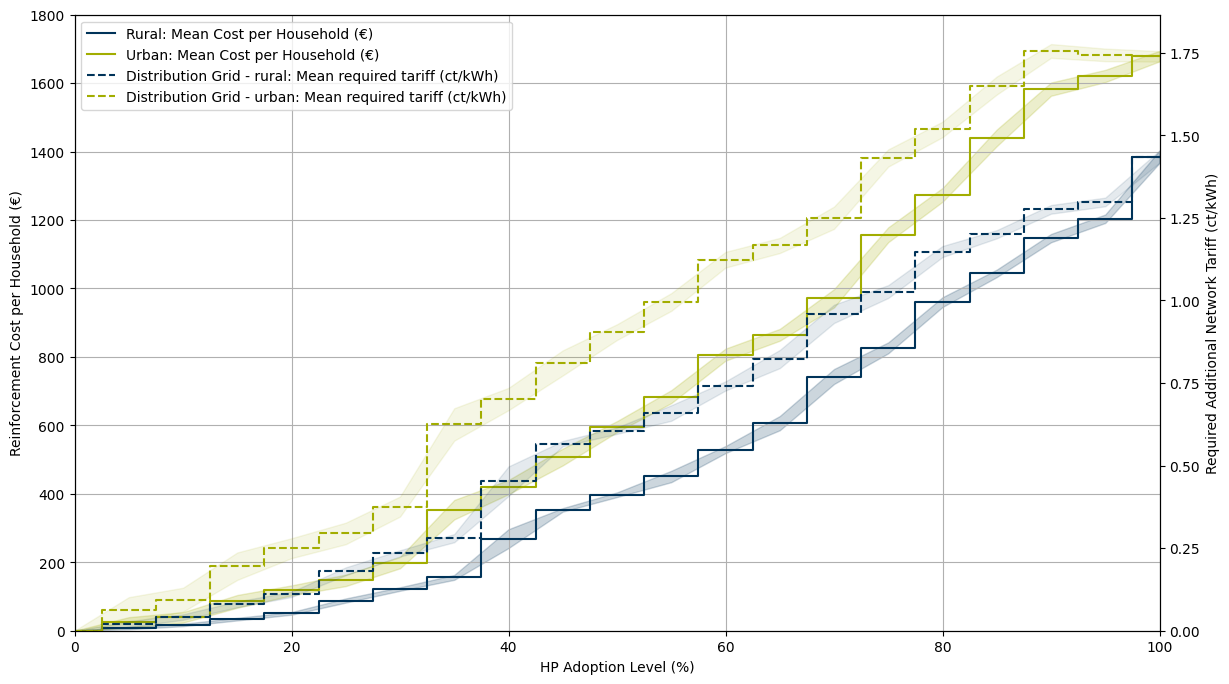

In [31]:
import matplotlib.pyplot as plt

def plot_combined_dual_axis(results_df, hv_mixed_summary, hv_urban_summary):
    # --- Filter for HV data ---
    hv_data = results_df[results_df['grid_level'] == 'HV']
    colors_and_labels = [
        {'color': '#003359', 'label': 'Distribution Grid - rural'},
        {'color': '#A2AD00', 'label': 'Distribution Grid - urban'}
    ]

    # --- Create figure and dual axes ---
    fig, ax1 = plt.subplots(figsize=(14, 8))
    ax2 = ax1.twinx()  # second y-axis

    # ------------------------
    # Left y-axis → Cost per Household
    # ------------------------
    ax1.step(hv_mixed_summary['HP_percentage'], hv_mixed_summary['mean'], where='mid',
             color='#003359', linestyle='-', label='Rural: Mean Cost per Household (€)')
    ax1.fill_between(hv_mixed_summary['HP_percentage'],
                     hv_mixed_summary['mean'] - hv_mixed_summary['std'],
                     hv_mixed_summary['mean'] + hv_mixed_summary['std'],
                     color='#003359', alpha=0.2)

    ax1.step(hv_urban_summary['HP_percentage'], hv_urban_summary['mean'], where='mid',
             color='#A2AD00', linestyle='-', label='Urban: Mean Cost per Household (€)')
    ax1.fill_between(hv_urban_summary['HP_percentage'],
                     hv_urban_summary['mean'] - hv_urban_summary['std'],
                     hv_urban_summary['mean'] + hv_urban_summary['std'],
                     color='#A2AD00', alpha=0.2)

    ax1.set_ylabel("Reinforcement Cost per Household (€)", color="black")
    ax1.set_ylim(0, 1800)

    # ------------------------
    # Right y-axis → Tariff (ct/kWh)
    # ------------------------
    for i, grid_code in enumerate(hv_data['grid_code'].unique()):
        grid_data = hv_data[hv_data['grid_code'] == grid_code]

        hp_adoption_levels = []
        required_tariffs_mean = []
        required_tariffs_std = []

        for hp_percentage in sorted(grid_data['HP_percentage'].unique()):
            hp_data = grid_data[grid_data['HP_percentage'] == hp_percentage]
            tariff_mean = hp_data['tariff_ct_without_HP_discount'].mean()
            tariff_std = hp_data['tariff_ct_without_HP_discount'].std()

            hp_adoption_levels.append(hp_percentage)
            required_tariffs_mean.append(tariff_mean)
            required_tariffs_std.append(tariff_std)

        color_info = colors_and_labels[i % len(colors_and_labels)]
        ax2.step(hp_adoption_levels, required_tariffs_mean, where='mid',
                 color=color_info['color'], linestyle='--',
                 label=f"{color_info['label']}: Mean required tariff (ct/kWh)")
        ax2.fill_between(hp_adoption_levels,
                         [m - s for m, s in zip(required_tariffs_mean, required_tariffs_std)],
                         [m + s for m, s in zip(required_tariffs_mean, required_tariffs_std)],
                         color=color_info['color'], alpha=0.1)

    ax2.set_ylabel("Required Additional Network Tariff (ct/kWh)", color="black")
    ax2.set_ylim(0)  # starts at 0, auto upper bound

    # ------------------------
    # Formatting
    # ------------------------
    ax1.set_xlabel("HP Adoption Level (%)")
    ax1.set_xlim(0, 100)
    # fig.suptitle("Combined: Reinforcement Cost per Household & Required Additional Network Tariff")

    # Combine legends from both axes
    lines_labels_1 = ax1.get_legend_handles_labels()
    lines_labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_labels_1[0] + lines_labels_2[0],
               lines_labels_1[1] + lines_labels_2[1],
               loc="upper left")

    ax1.grid(True)
    plt.show()


# Call function
plot_combined_dual_axis(results_df, hv_mixed_summary, hv_urban_summary)
